# Exploratory Data Analysis (EDA)

In this notebook, we load our pollen dataset (2D views generated from STL models) and analyze:

- The number of models in the dataset
- Visualization of randomly selected samples (left and right views, combined view)
- Calculation of a simple disparity/depth map using OpenCV Stereo Block Matching
- Visualization of a histogram of brightness values

**Note:** The `PollenDataset` class is imported from a separate folder.

In [1]:
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torch
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import cv2  # OpenCV for disparity map
sys.path.append("..")

from data import PollenDataset


## Load the Dataset

Here, we initialize the dataset and define transformations to convert images to grayscale tensors.

In [2]:

# Define the dataset directory
data_dir = os.getenv("DATA_DIR_PATH")
data_dir = os.path.join(data_dir, "raw")
processed_data_dir = os.getenv("DATA_DIR_PATH_PROCESSED")
print(f"Dataset directory: {data_dir}")

# Define image transformations
transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.ToTensor()
])

# Load the dataset
dataset = PollenDataset(data_dir, processed_dir=processed_data_dir, transform=transform, fold=5)
dataloader = DataLoader(dataset, batch_size=1, shuffle=False)

print(f"Total number of samples in dataset: {len(dataset)}")

Dataset directory: C:/Users/super/Documents/Github/sequoia/data\raw
Total number of samples in dataset: 41


## Visualizing Random Samples  

Below, we visualize a few random samples from the dataset. Each sample consists of:
- Left view
- Right view
- Combined view (concatenated left and right images)

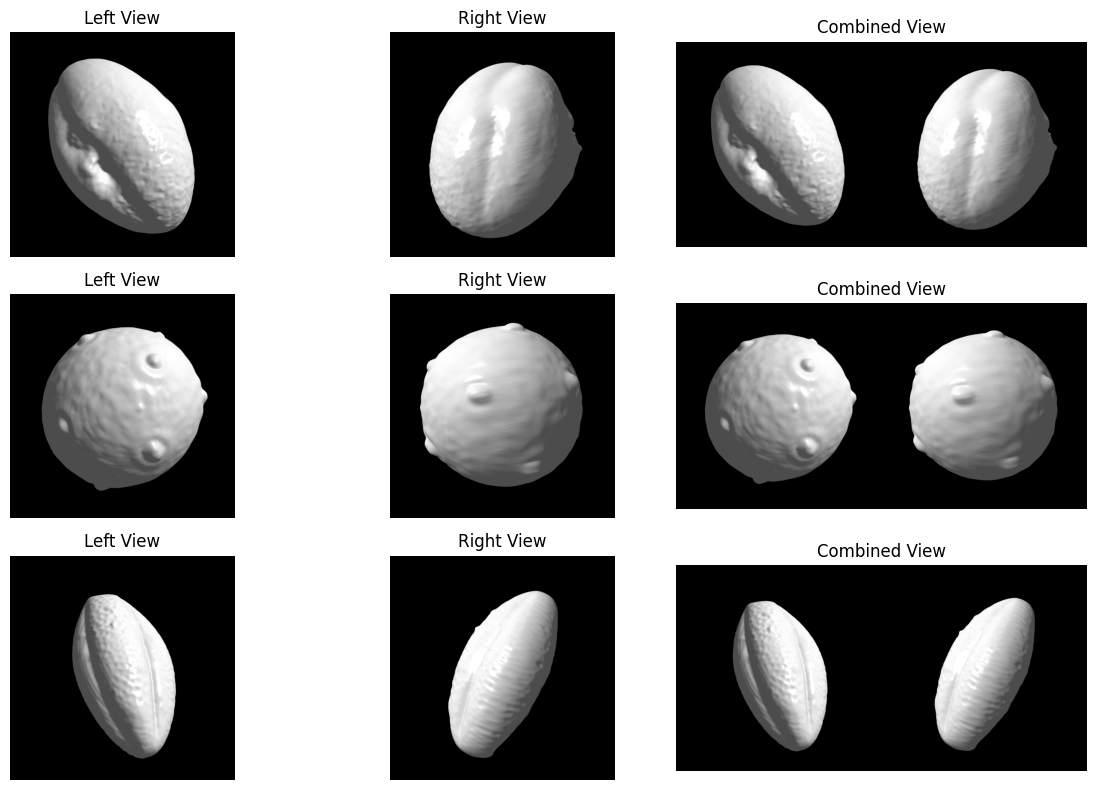

In [3]:

num_samples = 3
fig, axes = plt.subplots(num_samples, 3, figsize=(12, 8))

for i in range(num_samples):
    sample = dataset[i]
    left_img = sample['left_view'].numpy().squeeze()
    right_img = sample['right_view'].numpy().squeeze()
    combined = np.hstack([left_img, right_img])

    axes[i, 0].imshow(left_img, cmap='gray')
    axes[i, 0].set_title("Left View")
    axes[i, 0].axis("off")

    axes[i, 1].imshow(right_img, cmap='gray')
    axes[i, 1].set_title("Right View")
    axes[i, 1].axis("off")

    axes[i, 2].imshow(combined, cmap='gray')
    axes[i, 2].set_title("Combined View")
    axes[i, 2].axis("off")

plt.tight_layout()
plt.show()

## Compute Image Statistics  

We extract key statistics from the images:
- **Mean intensity**: Average brightness of the image.
- **Standard deviation**: Variation of pixel intensities.
- **Histogram**: Distribution of pixel intensities.

In [4]:
def compute_image_metrics(image):
    """Computes mean intensity, standard deviation, and histogram of an image."""
    image = image.numpy().squeeze() * 255  # Convert to numpy and scale to [0, 255]
    mean_intensity = np.mean(image)
    std_intensity = np.std(image)
    hist, _ = np.histogram(image, bins=256, range=(0, 256))
    return mean_intensity, std_intensity, hist

# Initialize lists to store metrics
mean_intensities = []
std_intensities = []
histograms = []

for sample in dataset:
    left_img = sample['left_view']
    right_img = sample['right_view']
    
    for img in [left_img, right_img]:
        mean_intensity, std_intensity, hist = compute_image_metrics(img)
        mean_intensities.append(mean_intensity)
        std_intensities.append(std_intensity)
        histograms.append(hist)

## Histogram of Mean Intensities  

The histogram below visualizes the spread of mean intensity values across the dataset.

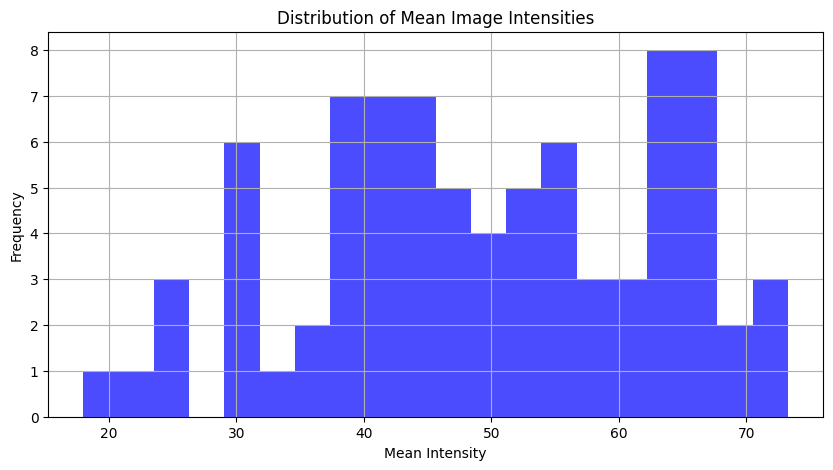

In [5]:

plt.figure(figsize=(10, 5))
plt.hist(mean_intensities, bins=20, color='blue', alpha=0.7)
plt.title("Distribution of Mean Image Intensities")
plt.xlabel("Mean Intensity")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

## Histogram of Standard Deviations  

This plot shows the variation in intensity values across the dataset. A higher standard deviation means more contrast.

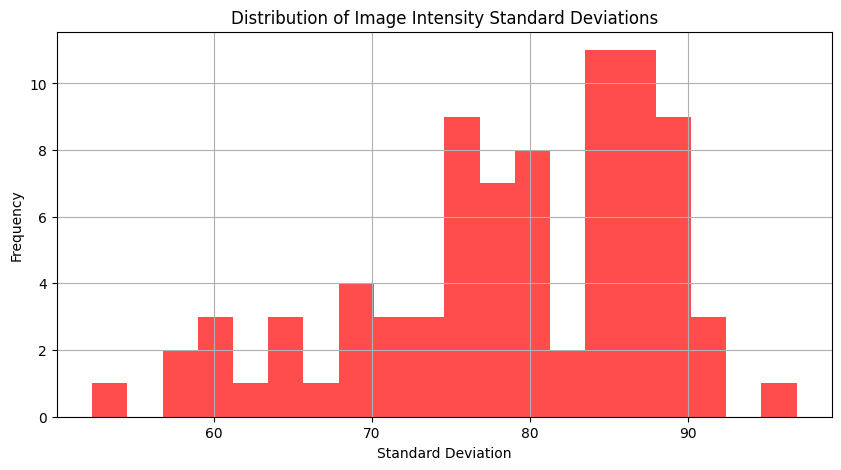

In [6]:

plt.figure(figsize=(10, 5))
plt.hist(std_intensities, bins=20, color='red', alpha=0.7)
plt.title("Distribution of Image Intensity Standard Deviations")
plt.xlabel("Standard Deviation")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

## Visualizing Sample Histograms  

Below, we plot pixel intensity histograms of three randomly selected images.

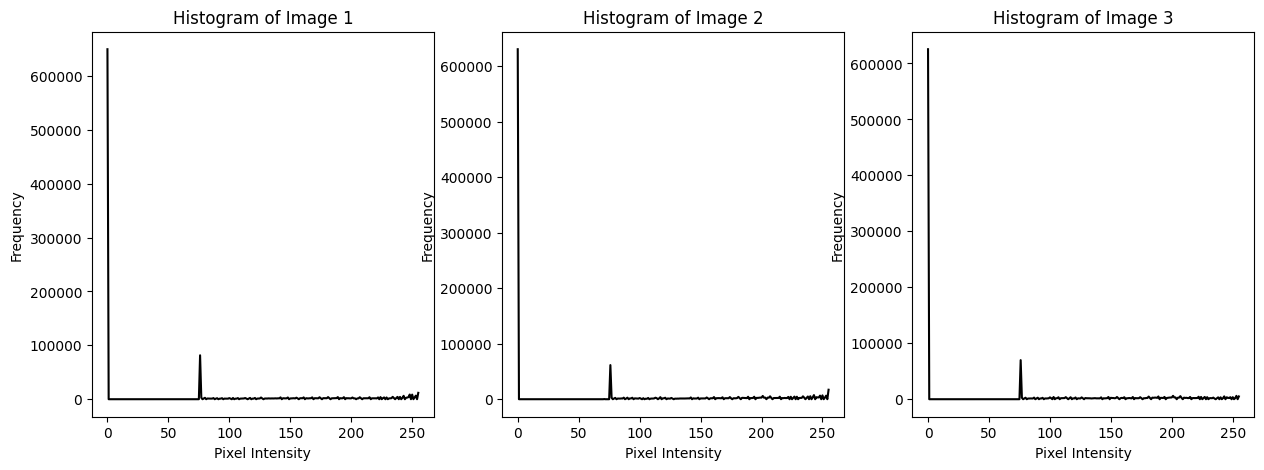

In [7]:

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for i in range(3):
    axes[i].plot(histograms[i], color='black')
    axes[i].set_title(f"Histogram of Image {i+1}")
    axes[i].set_xlabel("Pixel Intensity")
    axes[i].set_ylabel("Frequency")
plt.show()

## Computing a Simple Disparity Map  

We use OpenCV's **Stereo Block Matching (SBM)** to compute a basic disparity/depth map from a stereo image pair.

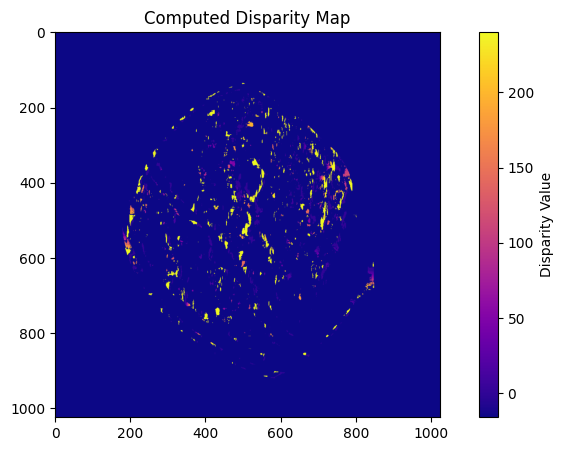

In [8]:
# Select a sample image pair
sample = dataset[0]
left_img = sample['left_view'].numpy().squeeze()
right_img = sample['right_view'].numpy().squeeze()

# Convert to uint8 (needed for OpenCV)
left_img = (left_img * 255).astype(np.uint8)
right_img = (right_img * 255).astype(np.uint8)

# Create a stereo block matcher
stereo = cv2.StereoBM_create(numDisparities=16, blockSize=15)
disparity = stereo.compute(left_img, right_img)

# Display the disparity map
plt.figure(figsize=(10, 5))
plt.imshow(disparity, cmap='plasma')
plt.colorbar(label="Disparity Value")
plt.title("Computed Disparity Map")
plt.show()

## Save Computed Metrics  

We save the computed statistics for further analysis and model training.

In [9]:
np.save("mean_intensities.npy", mean_intensities)
np.save("std_intensities.npy", std_intensities)